<a href="https://colab.research.google.com/github/AtharBagunaid/Face-mask-detector/blob/main/Soft_computing_Detect_Face_Mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.applications import vgg16
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import tensorflow
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
# from tensorflow.keras.applications import vgg16

In [2]:
!pwd

/content


In [3]:
cd "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection"

/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection


In [4]:
!pwd

/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection


## Data preparation

In [5]:
train_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/train"
valid_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/valid"
test_path = "/content/drive/MyDrive/Colab Notebooks/DIP/Mask_detection/test"

In [6]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 100, class_mode = 'categorical')
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 100, class_mode = 'categorical')
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size = (224,224), classes = ['with_mask', 'without_mask'], batch_size = 200, class_mode = 'categorical')

Found 4696 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [6]:
train_image_count = len([f for f in os.listdir(train_path)])
train_image_count

2

In [7]:
def plots(ims, figsize = (20,20), rows = 10, interp = False, titles = None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize = 16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [8]:
imgs, labels = next(train_batches) 

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


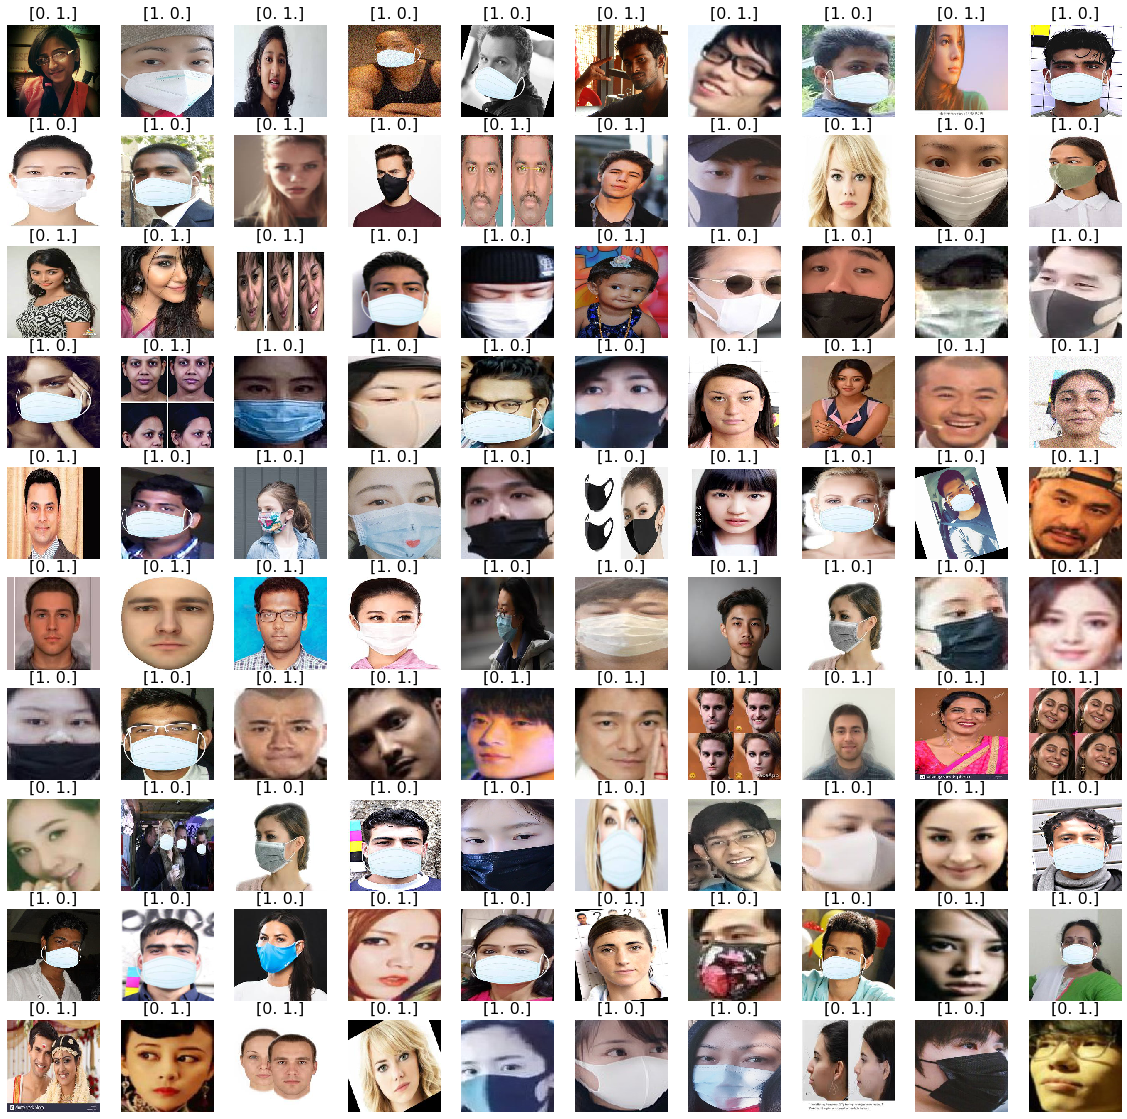

In [9]:
plots(imgs, titles = labels)   

## vgg-16 model preparation

In [11]:
vgg16_model = keras.applications.vgg16.VGG16()

In [12]:
# show the built in model structure
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# copy all layers of vgg16 into sequential model except the last layer
# then add output layer with 2 classes and softmax as activation function
model = Sequential()
for layer in vgg16_model.layers[:-1]:
  model.add(layer)

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

## Train the model using the train set

In [15]:
# Compile the model
model.compile(Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [16]:
# fitting / training the model
model.fit_generator(train_batches, steps_per_epoch=46, validation_data=valid_batches, validation_steps=5, epochs= 15, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
46/46 [==============================] - 115s 2s/step - loss: 0.7544 - accuracy: 0.6961 - val_loss: 0.3599 - val_accuracy: 0.8320
Epoch 2/15
46/46 [==============================] - 42s 915ms/step - loss: 0.1569 - accuracy: 0.9430 - val_loss: 0.2533 - val_accuracy: 0.8840
Epoch 3/15
46/46 [==============================] - 43s 922ms/step - loss: 0.1063 - accuracy: 0.9613 - val_loss: 0.1918 - val_accuracy: 0.9160
Epoch 4/15
46/46 [==============================] - 43s 920ms/step - loss: 0.0732 - accuracy: 0.9747 - val_loss: 0.1766 - val_accuracy: 0.9260
Epoch 5/15
46/46 [==============================] - 42s 918ms/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.1429 - val_accuracy: 0.9420
Epoch 6/15
46/46 [==============================] - 43s 919ms/step - loss: 0.0547 - accuracy: 0.9806 - val_loss: 0.1380 - val_accuracy: 0.9500
Epoch 7/15
46/46 [==============================] - 43s 920ms/step - loss: 0.0504 - accuracy: 0.9841 - val_loss: 0.1135 - val_accuracy: 0.9640
E

We notice from the above results that the accuracy increased from 0.6 at the first epoch up to 0.9794 in the last epoch

In [17]:
model.save('/content/drive/My Drive/Colab Notebooks/faceMask_detection.h5')
print('saved sucessfully')

saved sucessfully


In [7]:
vgg16_model1 = keras.applications.vgg16.VGG16()

model = Sequential()
for layer in vgg16_model1.layers[:-1]:
  model.add(layer)

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))

553476096/553467096 [==============================] - 6s 0us/step


In [8]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/faceMask_detection.h5')
classes = ["with mask", "without mask"]


In [9]:
# creating confusion matrix
# note that we to round up the predictions to avoid errors
test_images, test_labels = next(test_batches)
# this line just to make the labels one number instead of 2 so 0 for cats and 1 for dogs
test_labels = test_labels[:,0]   
test_labels

array([0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 1., 0.], dtype=float32)

In [10]:
predictions = model.predict_generator(test_batches, steps= 1, verbose = 0)
predictions

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([[5.07421719e-05, 9.99949217e-01],
       [9.99106348e-01, 8.93616350e-04],
       [1.78741102e-05, 9.99982119e-01],
       [1.41029045e-01, 8.58970940e-01],
       [9.96599495e-01, 3.40053695e-03],
       [9.95871723e-01, 4.12821630e-03],
       [6.37661515e-06, 9.99993682e-01],
       [2.65931187e-04, 9.99734104e-01],
       [5.70385410e-08, 1.00000000e+00],
       [9.46557462e-01, 5.34425266e-02],
       [5.86305261e-01, 4.13694769e-01],
       [3.19876242e-04, 9.99680161e-01],
       [5.61556760e-07, 9.99999404e-01],
       [1.28903270e-01, 8.71096671e-01],
       [9.60515261e-01, 3.94847728e-02],
       [8.63287369e-06, 9.99991417e-01],
       [2.38684397e-08, 1.00000000e+00],
       [3.70746083e-03, 9.96292531e-01],
       [5.27556722e-06, 9.99994755e-01],
       [9.19992745e-01, 8.00072029e-02],
       [6.72810435e-01, 3.27189565e-01],
       [1.25213237e-05, 9.99987483e-01],
       [2.60473367e-08, 1.00000000e+00],
       [1.00464351e-03, 9.98995364e-01],
       [6.411085

In [11]:
predictions.shape

(190, 2)

[[97  3]
 [ 4 86]]


Text(89.18, 0.5, 'predicted label')

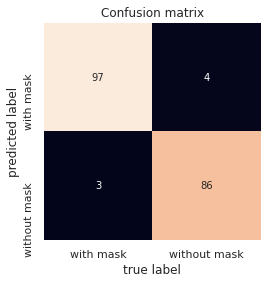

In [12]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
print(cm)

cm_labels = ['with mask', 'without mask']
# create the heat map
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False, 
            xticklabels=cm_labels, yticklabels=cm_labels)

#ploting heatmap of confusion matrix
plt.title("Confusion matrix")
plt.xlabel('true label')
plt.ylabel('predicted label')

In [16]:
# to display an image
from PIL import Image
import numpy as np
from skimage import transform
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

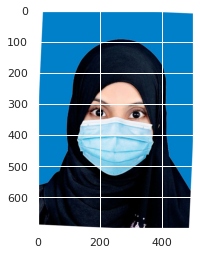

with mask


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [17]:
image = load("/content/drive/MyDrive/Uploads to transfer/with_mask_00.jpg")
img = mpimg.imread("/content/drive/MyDrive/Uploads to transfer/with_mask_00.jpg")
imgplot = plt.imshow(img)
plt.show()
print(classes[np.argmax(model.predict_generator(image))])

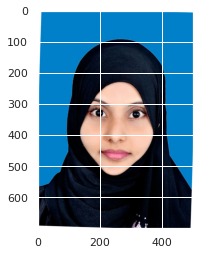

with mask


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [18]:
image1 = load("/content/drive/MyDrive/Uploads to transfer/with_mask_00.jpg")
img1 = mpimg.imread("/content/drive/MyDrive/Uploads to transfer/without_mask_00.jpg")
imgplot = plt.imshow(img1)
plt.show()
print(classes[np.argmax(model.predict_generator(image1))])

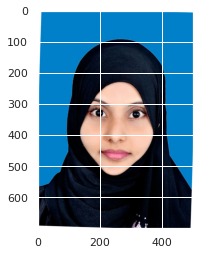

with mask


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [20]:
image2 = load("/content/drive/MyDrive/Uploads to transfer/without_mask_0.jpg")
img2 = mpimg.imread("/content/drive/MyDrive/Uploads to transfer/without_mask_00.jpg")
imgplot = plt.imshow(img2)
plt.show()
print(classes[np.argmax(model.predict_generator(image2))])